# Named Entity Recognition in TensorFlow - Demo
* Notebook by Adam Lang
* Date: 6/4/2024
* We will demo building a BiLSTM neural network Named Entity Recognition (NER) model using TensorFlow and a 'clean' dataset from Kaggle.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set random seed with numpy
np.random.seed(0)

## tensorflow
import tensorflow as tf
print('Version of Tensorflow is:', tf.__version__)

Version of Tensorflow is: 2.15.0


In [2]:
## import sklearn
import sklearn
print('Version of sklearn is:', sklearn.__version__)

Version of sklearn is: 1.2.2


## Load Data

In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/Text_Classification/ner_datasetreference.csv'

In [4]:
## upload dataset
df = pd.read_csv(data_path, encoding='unicode_escape')

#df head
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
## info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


## Named Entity Recognition - NER model

### Process for a NER problem
1.Define entity classes you want to extract
    * example: gene, disease, drugs, etc...
2. Gather relevant text data
3. Annotate + tag the data with labels
4. Train a NER model to predict the entities
    * Goal: classify into predicted categories

## Sequence Modeling Approach to NER

1. Training
* Collect a set of representative train examples (documents)
* Annotate each token for the entity class or other (O) using BIO encoding schema
* Feature engineering on data
* Train sequence tagger => predict labesl


2. Test
* Get the sample set of test examples.
* Run a sequence model inference to label each token.
* Return the named entities that were predicted/extracted.

## NER Encoding Schemas
* There are 7 known tagging schemes:

1. IO
2. IBO/BIO
3. IOE
4. IOBES/BIOES
5. BI
6. IE
7. BIES

* Encoding schema defined:
   * I → “inside”
   * O → “outside”
   * B → “beginning”
   * E → “end”
   * S → “single token entity


* IO
  * This is the simplest form of tagging where each token from a sentence is assigned one of two tags: inside tag (I) or outside tag (O).
  * If a token is an entity, it is tagged as I or else as O.
  * Disadvantage: This scheme cannot correctly encode consecutive entities of the same type.

* **IOB/BIO**
  * This is the most common scheme.
  * In this tagging, we assign a tag to each word in the text, determining whether it is the:
    * beginning (B) of a known named entity
    * inside (I) it
    * outside (O) of any known named entities

* IOE
  * This is nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

* IOBES/BIOES
  * This is an alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the:
    * beginning (B)
    * inside (I)
    * end (E)
    * outside (O) of a named entity
    * also labels the **single-token entities with the tag.**

* BI
  * Tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O

* IE
  * This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.


* BIES
  * Encodes entities similar to IOBES.
  * It also encodes the non-entity words using the same method, it is as follows:
    * B-O to tag the beginning of non-entity words
    * I-O to tag the inside of non-entity words
    * S-O for single non-entity tokens that exist between two entities.



## BIO encoding schema - we will use this one
* **IOB/BIO**
  * This is the most common scheme.
  * In this tagging, we assign a tag to each word in the text, determining whether it is the:
    * beginning (B) of a known named entity
    * inside (I) it
    * outside (O) of any known named entities
* Example:
    * Sentence: Tom is from California.
    * Encoded Sentence: B-Person 0 0 B-Location I-Location 0

## Exploratory Data Analysis
* 4 columns in data (from kaggle)
  1. sentence number
  2. word
  3. part of speech tag of word
  4. NER tag associated with each word

### Important metadata
* `geo` = Geographical Entity
* `org` = Organization
* `per` = Person
* `gpe` = Geopolitical Entity
* `tim` = Time indicator
* `art` = Artifact
* `eve` = Event
* `nat` = Natural Phenomenon

In [6]:
## shape of data
df.shape

(1048575, 4)

## Data preprocessing for modeling

### 1. Check if null values exist

In [7]:
## check null values
df.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

### 2. Fill the null values

In [8]:
## fill null values
df = df.fillna(method='ffill') #fill along column axis
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### 3. Check if null values were filled

In [9]:
## check null
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [10]:
# check cols
df.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

### 4. What are the NER tags?

In [11]:
## What are the NER tags?
df['Tag'].value_counts(dropna=False)

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [12]:
## how many tags are there
print(f"There are {len(df['Tag'].value_counts())} tags")

There are 17 tags


### 5. We need to create a list of sentences and a list of NER tags with each sentence grouped
* We need to go from word level to sentence level

In [13]:
## we need to create a list of sentences and list of NER tags with each sentence
agg_funcs = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                    s['POS'].values.tolist(),
                                                    s['Tag'].values.tolist())]

In [14]:
## add this to the data
agg_df = df.groupby(['Sentence #']).apply(agg_funcs).reset_index().rename(columns={0: 'Sentence_POS_Tag_Pairs'})
agg_df.head()

,Sentence #,Sentence_POS_Tag_Pairs
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s..."
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat..."
3,Sentence: 1000,"[(They, PRP, O), (left, VBD, O), (after, IN, O..."
4,Sentence: 10000,"[(U.N., NNP, B-geo), (relief, NN, O), (coordin..."


Summary:
* We started with "word" level data and now we have "Sentence level" data.
* Each sentence is a tuple with raw word and tag.

In [15]:
## now we need to parse this out
agg_df['Sentence']=agg_df['Sentence_POS_Tag_Pairs'].apply(lambda sentence: " ".join([s[0] for s in sentence]))
agg_df['POS']=agg_df['Sentence_POS_Tag_Pairs'].apply(lambda sentence: " ".join([s[1] for s in sentence]))
agg_df['Tag']=agg_df['Sentence_POS_Tag_Pairs'].apply(lambda sentence: " ".join([s[2] for s in sentence]))

In [16]:
## what is the shape of this now?
agg_df.shape

(47959, 5)

In [17]:
## head of df
agg_df.head()

,Sentence #,Sentence_POS_Tag_Pairs,Sentence,POS,Tag
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat...",Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s...",Iranian officials say they expect to get acces...,JJ NNS VBP PRP VBP TO VB NN TO JJ JJ NNS IN DT...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat...",Helicopter gunships Saturday pounded militant ...,"NN NNS NNP VBD JJ NNS IN DT NNP JJ NN , WRB JJ...",O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,Sentence: 1000,"[(They, PRP, O), (left, VBD, O), (after, IN, O...",They left after a tense hour-long standoff wit...,PRP VBD IN DT NN JJ NN IN NN NNS .,O O O O O O O O O O O
4,Sentence: 10000,"[(U.N., NNP, B-geo), (relief, NN, O), (coordin...",U.N. relief coordinator Jan Egeland said Sunda...,"NNP NN NN NNP NNP VBD NNP , NNP , JJ CC JJ JJ ...",B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


### 6. Tokenize the Sentences
* We will tokenize using white space `.split()` method in Python.
* This is the simple approach.

In [18]:
## tokenization using built in .split() whitespace function

## Sentence splits on white space
agg_df['tokenized_sentences']=agg_df['Sentence'].apply(lambda x:x.split())

## Tag splits on white space
agg_df['tag_list']=agg_df['Tag'].apply(lambda x:x.split())

## print head of df
agg_df.head()

,Sentence #,Sentence_POS_Tag_Pairs,Sentence,POS,Tag,tokenized_sentences,tag_list
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat...",Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s...",Iranian officials say they expect to get acces...,JJ NNS VBP PRP VBP TO VB NN TO JJ JJ NNS IN DT...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat...",Helicopter gunships Saturday pounded militant ...,"NN NNS NNP VBD JJ NNS IN DT NNP JJ NN , WRB JJ...",O O B-tim O O O O O B-geo O O O O O B-org O O ...,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,Sentence: 1000,"[(They, PRP, O), (left, VBD, O), (after, IN, O...",They left after a tense hour-long standoff wit...,PRP VBD IN DT NN JJ NN IN NN NNS .,O O O O O O O O O O O,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[(U.N., NNP, B-geo), (relief, NN, O), (coordin...",U.N. relief coordinator Jan Egeland said Sunda...,"NNP NN NN NNP NNP VBD NNP , NNP , JJ CC JJ JJ ...",B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."


### 7. Remove sentences where NER tag is not matching word list

In [19]:
agg_df['len_sentence']=agg_df['tokenized_sentences'].apply(lambda x:len(x))
agg_df['len_tag']=agg_df['tag_list'].apply(lambda x:len(x))
agg_df['is_equal']=agg_df.apply(lambda row:1 if row['len_sentence']==row['len_tag'] else 0,axis=1)
agg_df['is_equal'].value_counts()

is_equal
1    47955
0        4
Name: count, dtype: int64

In [20]:
## which are not equal?
agg_df=agg_df[agg_df['is_equal']!=0]

In [21]:
agg_df.shape

(47955, 10)

In [22]:
### lets look at the sentences now
sentences_list=agg_df['Sentence'].tolist()
tags_list=agg_df['tag_list'].tolist()

print(f"Number of sentences in the data: ", {(len(sentences_list))})
print("Are the num of sentences and tag list equal: ",len(sentences_list)==len(tags_list))

Number of sentences in the data:  {47955}
Are the num of sentences and tag list equal:  True


In [23]:
## what are the first tags
tags_list[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

# Tokenization
* We need to create a vocab of words and then each word needs to be assigned to a unique ID.
* The Keras library has an API for Tokenization which we can utilize for this.
  * This will tokenize + encode sentences at the same time.
* There are also sentences with different lengths so we will need to **pad** the input sequences to the longest sentence length.
  * Keras also has a `pad_sequences` function to do this.
* **We need all input sentences to be of equal length for this to work**

### Encode Sentences using Keras Tokenizer

In [24]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False,filters='')

## fit on sentences_list
tokenizer.fit_on_texts(sentences_list)

In [25]:
## get the size of tokenizer
print(f"The Vocabulary size of the Tokenizer is: {len(tokenizer.word_index)+1}") ## adding 1 because 0 is used for padding

The Vocabulary size of the Tokenizer is: 35169


In [26]:
## lets index a word in the tokenizer
tokenizer.index_word[325]

'House'

### Look at word -> index dictionary

In [27]:
encoded_sent = tokenizer.texts_to_sequences(sentences_list)
print('First original sentence:\n', sentences_list[0])
print('First encoded sentence:\n', encoded_sent[0])
print('Is length of original sentence the same as the encoded sentence:\n',len(sentences_list[0].split())==len(encoded_sent))
print('Length of first sentence: ', len(encoded_sent[0]))

First original sentence:
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
First encoded sentence:
 [1114, 4, 1161, 16, 1852, 230, 478, 6, 533, 1, 155, 5, 58, 8, 582, 1, 843, 4, 179, 87, 21, 15, 52, 2]
Is length of original sentence the same as the encoded sentence:
 False
Length of first sentence:  24


### Create Tags Mapping and Encode the Tags

In [28]:
tags = list(set(df['Tag'].values))
print(tags)

['B-nat', 'I-gpe', 'B-art', 'I-art', 'O', 'I-org', 'B-tim', 'B-gpe', 'I-geo', 'I-per', 'B-geo', 'B-eve', 'I-nat', 'I-tim', 'B-per', 'I-eve', 'B-org']


In [29]:
## get num of tags
num_tags=len(tags)
print("Number of Tags: ", num_tags)

Number of Tags:  17


In [30]:
## create the tags map
tags_map = {tag:i for i, tag in enumerate(tags)}
print("Tags Map ", tags_map)

Tags Map  {'B-nat': 0, 'I-gpe': 1, 'B-art': 2, 'I-art': 3, 'O': 4, 'I-org': 5, 'B-tim': 6, 'B-gpe': 7, 'I-geo': 8, 'I-per': 9, 'B-geo': 10, 'B-eve': 11, 'I-nat': 12, 'I-tim': 13, 'B-per': 14, 'I-eve': 15, 'B-org': 16}


Summary:
* Each entity in the tags map now has a prefix `B-` or `I-`.
* `B-` is the beginning and `I-` is the inside of an entity.
* Prefixes are used to detect multiword entities.

In [31]:
## reverse tags map
reverse_tag_map = {v: k for k, v in tags_map.items()}

In [32]:
## get encoded tags
encoded_tags = [[tags_map[w] for w in tag] for tag in tags_list]
print("First sentence:\n", sentences_list[0])
print('First sentence original tags are:\n', tags_list[0])
print("Is the length of the original Tags and Encoded Tags the same: ", len(tags_list[0])==len(encoded_tags[0]))
print("Length of Tags for First Sentence: ", len(encoded_tags[0]))

First sentence:
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
First sentence original tags are:
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
Is the length of the original Tags and Encoded Tags the same:  True
Length of Tags for First Sentence:  24


### Plot histogram of sentence lengths

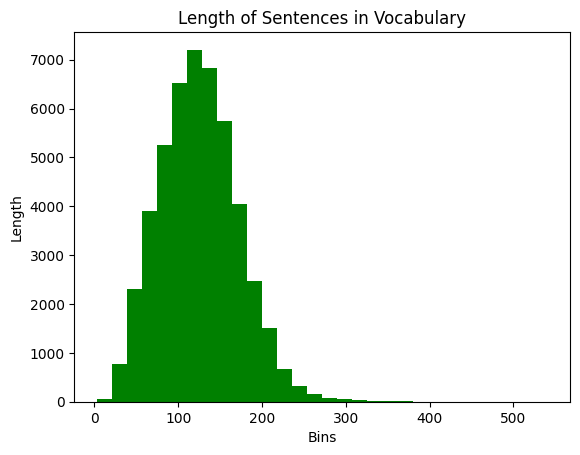

In [33]:
## histogram plot
plt.hist([len(sen) for sen in sentences_list], bins=30, color='green')
plt.title('Length of Sentences in Vocabulary')
plt.xlabel('Bins')
plt.ylabel('Length')
plt.show();

Summary:
* Most of the sentence lengths are between 0 and 200 with some outliers.
* The median length appears to be just over 100.

In [34]:
## lets also get the maximum sentence length
max_sentence_length = max([len(s.split()) for s in sentences_list])
print(max_sentence_length)

104


Summary
* So now we can see that 50 will be a good number for sequence length and 104 is the maximum sequence length.
* However, instead of using 104 as the sequence length, lets choose the nearest power of 2 as sequence length --- which is 128.
* The encoded sentences we will use 0 as padding token
* Tags token index will be 'O'

In [35]:
## set max length
max_len = 128
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

padded_encoded_sentences = pad_sequences(maxlen=max_len, sequences=encoded_sent,padding='post',value=0)
padded_encoded_tags = pad_sequences(maxlen=max_len, sequences=encoded_tags, padding='post', value=tags_map['O'])

In [36]:
## now get the shapes
print("The Shape of encoded sentence: ", padded_encoded_sentences.shape)
print("The Shape of encoded labels: ", padded_encoded_tags.shape)

print("First encoded sentence without padding:\n",encoded_sent[0])
print("First encoded sentence with padding:\n",padded_encoded_sentences[0])
print("First sentence encoded label without padding:\n", encoded_tags[0])
print("First sentence encoded label with padding:\n", padded_encoded_tags[0])

The Shape of encoded sentence:  (47955, 128)
The Shape of encoded labels:  (47955, 128)
First encoded sentence without padding:
 [1114, 4, 1161, 16, 1852, 230, 478, 6, 533, 1, 155, 5, 58, 8, 582, 1, 843, 4, 179, 87, 21, 15, 52, 2]
First encoded sentence with padding:
 [1114    4 1161   16 1852  230  478    6  533    1  155    5   58    8
  582    1  843    4  179   87   21   15   52    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
First sentence encoded label without padding:
 [4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4

### Convert target variable into categorical variable

In [37]:
target = [to_categorical(i,num_classes = num_tags) for i in padded_encoded_tags]
print("The shape of the labels after converting to categorical for 1st sentence is: ", target[0].shape)

The shape of the labels after converting to categorical for 1st sentence is:  (128, 17)


# Train, Test, Validation Data splits

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train,y_val_test = train_test_split(padded_encoded_sentences, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.2, random_state=42)

print("Input train data shape: ", X_train.shape)
print("Train labels length: ", len(y_train))
print("Input test data shape: ", len(X_test.shape))
print("Test labels length: ", len(y_test))

print("Input validation data shape: ",X_val.shape)
print("Validation labels length: ",len(y_val))

Input train data shape:  (33568, 128)
Train labels length:  33568
Input test data shape:  2
Test labels length:  2878
Input validation data shape:  (11509, 128)
Validation labels length:  11509


In [39]:
# print first sample of each
print("First sentence in the training data: ", X_train[0])
print("First sentence label: ", y_train[0])
print("Shape of first sentence X_train: ", X_train[0].shape)
print("Shape of first sentence label y_train: ", y_train[0].shape)

First sentence in the training data:  [ 144    1  873   20  198   13  132 1682    4    7  416 3636    5    1
 1396  653    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
First sentence label:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of first sentence X_train:  (128,)
Shape of first sentence label y_train:  (128, 17)


# NER Modeling wiht BiLSTMs
* LSTMs have predominantly been used in the analysis of the sequential type of data. In terms of Natural language processing, LSTM has a high advantage because it is able to identify the contrasting feature of every token sequentially.
* BiLSTM or Bi-directional LSTM has the ability to analyze inputs from both directions, namely, the past and the future timestamps.
* BiLSTM, it divides the whole sentence into a sequence of components with every word being an individual component. Hence, it will essentially provide a different output for every component present in the entire sequence and ultimately provide the required output to the user.
* **The main problem with a BiLSTM is the fact that it takes a longer period of time for training as a result of which, the time complexity of the model might increase.**

In [40]:
## imports
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional


In [41]:
## modeling
embedding_dim = 128
vocab_size = len(tokenizer.word_index)+1
lstm_units=128
max_len=128

# input and embeddings
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = vocab_size+1, output_dim = embedding_dim, input_length = max_len)(input_word)

model = Bidirectional(LSTM(units=embedding_dim, return_sequences=True))(model)
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model) #softmax converts raw logits into probability outputs
model = Model(input_word, out)


## print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          4501760   
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          263168    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 128, 17)           4369      
 ributed)                                                        
                                                                 
Total params: 4769297 (18.19 MB)
Trainable params: 4769297 (18.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile model
* We will use categorical crossentropy common for multi-class classification problems.
* This is also called `Softmax Loss`. It is a Softmax activation plus a Cross-Entropy loss. If we use this loss, we will train a CNN to output a probability over the classes for each image. It is used for multi-class classification.

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

### Train the model

In [43]:
history = model.fit(X_train, np.array(y_train), validation_data=(X_val, np.array(y_val)), batch_size=32, epochs=3)

Epoch 1/3
1049/1049 [==============================] - 39s 29ms/step - loss: 0.0783 - accuracy: 0.9838 - val_loss: 0.0240 - val_accuracy: 0.9930
Epoch 2/3
1049/1049 [==============================] - 17s 17ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0194 - val_accuracy: 0.9942
Epoch 3/3
1049/1049 [==============================] - 17s 16ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0189 - val_accuracy: 0.9943


# Evaluation
* Now we need to evaluate the model results.
* We need to remove the padding and look at the accuracy of predictions.
* We will need to create a dataframe with the tokens, actual and predicted values and calculate the metrics.

In [44]:
# predict using the model outputs on the test data
preds=model.predict(X_test)

90/90 [==============================] - 1s 5ms/step


In [45]:
### define a function to evalute the predictions
def evaluate_preds(test_data, preds, actual_preds):
  print("Shape of Test data array", test_data.shape)
  y_actual=np.argmax(np.array(actual_preds),axis=2)
  y_pred=np.argmax(preds,axis=2)
  num_test_data=test_data.shape[0]
  print("Number of test data points ",num_test_data)
  data=pd.DataFrame()
  df_list=[]
  for i in range(num_test_data):
    test_str=list(test_data[i])
    df_new=pd.DataFrame()
    df_new['test_tokens']=test_str
    df_new['tokens']=df_new['test_tokens'].apply(lambda x:tokenizer.index_word[x] if x!=0 else '<PAD>')
    df_new['actual_target_index']=list(y_actual[i])
    df_new['pred_target_index']=list(y_pred[i])
    df_new['actual_target_tag']=df_new['actual_target_index'].apply(lambda x:reverse_tag_map[x])
    df_new['pred_target_tag']=df_new['pred_target_index'].apply(lambda x:reverse_tag_map[x])
    df_new['id']=i+1
    df_list.append(df_new)
  data=pd.concat(df_list)
  pred_data=data[data['tokens']!='<PAD>']
  accuracy=pred_data[pred_data['actual_target_tag']==pred_data['pred_target_tag']].shape[0]/pred_data.shape[0]


  return pred_data, accuracy

In [46]:
pred_data, accuracy = evaluate_preds(X_test, preds, y_test)

Shape of Test data array (2878, 128)
Number of test data points  2878


### Calculate Precision + Recall of each Class + F1 score

In [47]:
y_pred=pred_data['pred_target_tag'].tolist()
y_actual=pred_data['actual_target_tag'].tolist()

In [48]:
## import classification report
from sklearn.metrics import classification_report

In [49]:
print("Classification Report for NER BiLSTM Model")
print(classification_report(y_actual,y_pred))

Classification Report for NER BiLSTM Model


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        25
       B-eve       1.00      0.11      0.19        19
       B-geo       0.86      0.89      0.88      2190
       B-gpe       0.94      0.92      0.93       909
       B-nat       0.50      0.20      0.29         5
       B-org       0.78      0.72      0.75      1170
       B-per       0.85      0.83      0.84      1026
       B-tim       0.86      0.90      0.88      1244
       I-art       0.00      0.00      0.00        13
       I-eve       0.50      0.12      0.19        17
       I-geo       0.86      0.74      0.80       419
       I-gpe       1.00      0.28      0.43        18
       I-nat       0.00      0.00      0.00         1
       I-org       0.80      0.78      0.79       995
       I-per       0.91      0.84      0.87      1090
       I-tim       0.74      0.73      0.73       386
           O       0.99      0.99      0.99     53126

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
## pred data head
pred_data.head(30)

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
0,47,A,4,4,O,O,1
1,252,top,4,4,O,O,1
2,25,U.S.,10,10,B-geo,B-geo,1
3,151,official,4,4,O,O,1
4,365,met,4,4,O,O,1
5,17,with,4,4,O,O,1
6,7062,Nicaraguan,7,4,B-gpe,O,1
7,3479,President-elect,4,4,O,O,1
8,4053,Daniel,14,14,B-per,B-per,1
9,7063,Ortega,9,9,I-per,I-per,1


### Look at predictions for artifact

In [51]:
pred_data[pred_data['actual_target_tag']=='B-art']

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
9,9369,Vioxx,2,16,B-art,B-org,27
11,3852,Camp,2,14,B-art,B-per,223
7,25978,alHurra,2,5,B-art,I-org,596
29,8156,Please,2,4,B-art,O,690
31,8156,Please,2,14,B-art,B-per,690
33,8156,Please,2,14,B-art,B-per,690
4,7381,Telegraph,2,10,B-art,B-geo,734
30,4008,Nuclear,2,16,B-art,B-org,776
5,30306,mon,2,4,B-art,O,858
5,20252,Soprano,2,5,B-art,I-org,1550


It seems the model HAS NOT done a good job finding the NER tags for works of art. However it has recognized some of the geographical places correctly.

In [52]:
pred_data[pred_data['actual_target_tag']=='B-geo'][0:5]

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
2,25,U.S.,10,10,B-geo,B-geo,1
1,25,U.S.,10,10,B-geo,B-geo,3
18,58,Iraq,10,10,B-geo,B-geo,4
9,4956,Johannesburg,10,10,B-geo,B-geo,6
28,58,Iraq,10,10,B-geo,B-geo,6


### Let's look at B-gpe as this had the highest precision and recall

In [53]:
pred_data[pred_data['actual_target_tag']=='B-gpe'][0:10]

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
6,7062,Nicaraguan,7,4,B-gpe,O,1
8,110,Palestinian,7,7,B-gpe,B-gpe,11
10,4480,Malaysian,7,7,B-gpe,B-gpe,16
25,297,French,7,7,B-gpe,B-gpe,21
7,741,Syrian,7,7,B-gpe,B-gpe,22
0,297,French,7,7,B-gpe,B-gpe,24
2,110,Palestinian,7,7,B-gpe,B-gpe,29
2,1744,Israelis,7,7,B-gpe,B-gpe,34
5,561,Palestinians,7,7,B-gpe,B-gpe,34
2,281,African,7,7,B-gpe,B-gpe,37


Summary
* It looks like the model did a good job predicting the B-gpe label.

### What about the NER tage b-eve

In [54]:
pred_data[pred_data['actual_target_tag']=='B-eve'][0:10]

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
1,190,World,11,4,B-eve,O,64
3,14487,Coming,11,4,B-eve,O,144
0,1521,Christmas,11,10,B-eve,B-geo,236
17,1152,II,11,13,B-eve,I-tim,248
16,190,World,11,11,B-eve,B-eve,273
15,4626,Operation,11,4,B-eve,O,701
30,1152,II,11,15,B-eve,I-eve,993
6,713,I,11,13,B-eve,I-tim,1022
8,1152,II,11,11,B-eve,B-eve,1022
1,827,Hurricane,11,4,B-eve,O,1033


Summary
* This is interesting because although the model precision was 1.00 the recall was 0.11 and we can see the predictions are not even close to 100% correct.

# How could we improve the BiLSTM model?
* Pre-trained word embeddings or sentence embeddings (SBERT)
* BERT models with fine-tuning.
* We can also fine tune the model hyperparameters such as:
  * epochs
  * LSTM units (number of units)
  * Activation Function
  * Add dropout hidden layers
  * Add Early stopping
  * Add batch normalization
  * etc....